# Marketing portuguese bank campaigns

This dataset is available [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) and is related with a marketing campaign, based on phone calls, of a Portuguese banking institution. The objective was to lead the client to make a term deposit.

There are 16 variables plus the target:

###### client data
1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                   "blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

###### related with the last contact of the current campaign:
9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

###### other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

###### Output variable (desired target):
17. y - has the client subscribed a term deposit? (binary: "yes","no")

# Objectives

My objective here is to apply and practice some tools I've been studying and to present an EDA of the data, in order to assist this bank marketing team to interpret and improve their marketing campaign and create some models to help them to predict if a client will subscribe to a term deposit or no. This algorithm can help them to reduce their customer acquisition cost (CAC).


### Questions to answer to this bank's marketing team

1. Demographic overview about clients who did a term deposit
2. Period of year and month users were contacted
3. Average balance of clients
4. Campaign statistics



In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing dataset and taking a look at first rows
df = pd.read_csv('dataset/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# EDA
Taking a look at the data

In [3]:
# df shape
df.shape

(45211, 17)

At first, looks like there is no missing data at the dataset. However, the description of the data at UCI website point us that some rows have a "unknown" value and this could be interpret at a missing data or as a category.


In [4]:
# missing data
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

If we interpret contact unknown as a missing data, 29% of this column will be missing. This data is from 2008 and 2010 and at that time, Portugal population was around 10,5 million with around [13 million mobile phone subscribers](https://www.theglobaleconomy.com/Portugal/Mobile_phone_subscribers/) (some users might had more than one line?). So, I will change "unknown" for cellular here.

In [5]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [6]:
#mapping unknown values to cellular
df['contact'] = df.contact.apply(lambda x: 'cellular' if x=='unknown' else x)
df.contact.value_counts()

cellular     42305
telephone     2906
Name: contact, dtype: int64

One last column I want to take a look at unknown values is 'poutcome' (previous marketing campaign). Since 82% of this columns is 'unknown', I will drop this column because I think this does not contribute much to our analysis.

In [7]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

Taking a look at the describe of this dataframe we can understand some quick informations:
* Minimum age is 18 (maybe is the minumum age to open a bank account at Portugal?). Maximum age is 95. Mean age is ~41.
* Balance has a lot of dispersion. At least one client have a negative balance. Maximum balance is higher than 100.000
* Mean marketing call duration was about 4 minutes.
* Mean number of calls done to the same user was 2
* Previous looks like there is some outliers. Maximum value here is 275 which means the client was contacted 275 times before the campaign? This value seems off to me.
* pdays I will convert in a category. -1 will be never_contacted and other values will be already_contacted

In [8]:
# Describe
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
# creating new column to transform pdays in categories
df['campaign_contact'] = df.pdays.apply(lambda x: 'never_contacted' if x<0 else 'already_contacted')

In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,campaign_contact
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,unknown,no,never_contacted
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,unknown,no,never_contacted
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,unknown,no,never_contacted
3,47,blue-collar,married,unknown,no,1506,yes,no,cellular,5,may,92,1,-1,0,unknown,no,never_contacted
4,33,unknown,single,unknown,no,1,no,no,cellular,5,may,198,1,-1,0,unknown,no,never_contacted


In [48]:
# creating a function to plot single column categories
def plot_category(column, hue=None, df=df, order=False, title=None, yaxis=None, xaxis=None, img_filename=None):
    
    fig, ax = plt.subplots(figsize=(18,10))
    if order:
        if order == bool:
            ax = sns.countplot(y=column, hue=hue, data=df, order=df[column].value_counts().index, palette='rocket')
        else:
            ax = sns.countplot(y=column, hue=hue, data=df, order=order, palette='rocket')
    else:
        ax = sns.countplot(y=column, hue=hue, data=df)
    ax.set_xlabel(xaxis, fontsize=15)
    ax.set_ylabel(yaxis, fontsize=15)
    ax.set_title(title, fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    if img_filename:
        fig.savefig(f'images/{img_filename}')
    plt.show()
    
def plot_cat(column, col=None, df=df, title=None, yaxis=None, xaxis=None, kind='count', img_filename=None):
    fig = sns.catplot(y=column, col=col, data=df, order=df[column].value_counts().index, kind=kind, palette='rocket', height=6, aspect=1)
    fig.set_axis_labels(xaxis, yaxis)
    fig.fig.suptitle(title,
                  fontsize=18)
    if img_filename:
        fig.savefig(f'images/{img_filename}')
    plt.show()

The majority of clients in the bank work on a blue-collar and management positions, married with secondary degree of education and without personal loan but with housing loan.

Also, more people at management, technician and admin did deposits. And its important to notice that, as I mention above the majority of people at the dataset does have a housing loan but most people without this loan did a deposit.

Most calls were done at may, jun, jul and aug with a huge spike at may and between 16 and 21 of months days

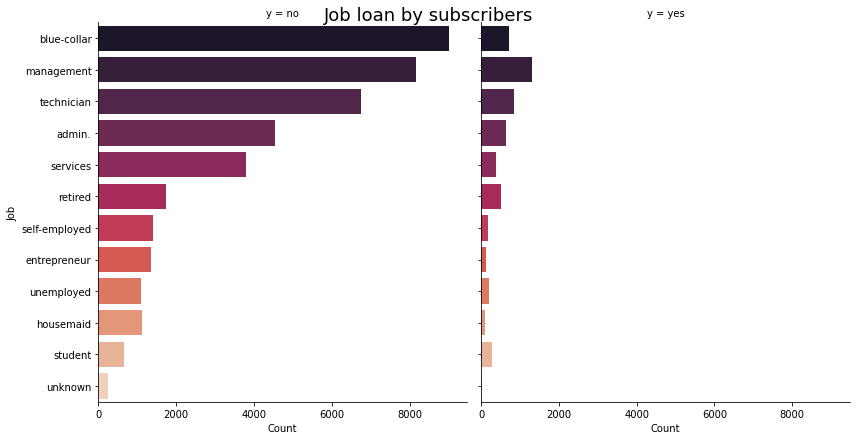

In [53]:
# job visualization
plot_cat(column='job', col='y', xaxis='Count', yaxis='Job', title='Job loan by subscribers', img_filename='deposits_by_job.jpg')

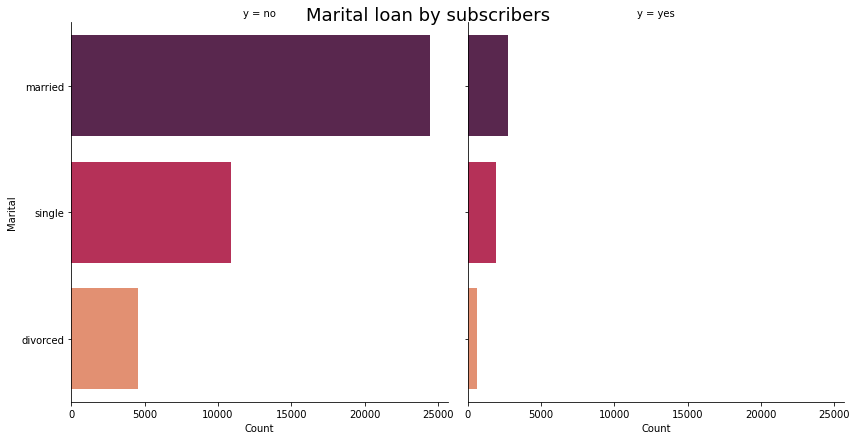

In [52]:
#marital
# plot_category('marital', order=True, title='Job distribution among clients', yaxis='Job', xaxis='Count')
plot_cat(column='marital', col='y', xaxis='Count', yaxis='Marital', title='Marital loan by subscribers', img_filename='deposits_by_marital.jpg')

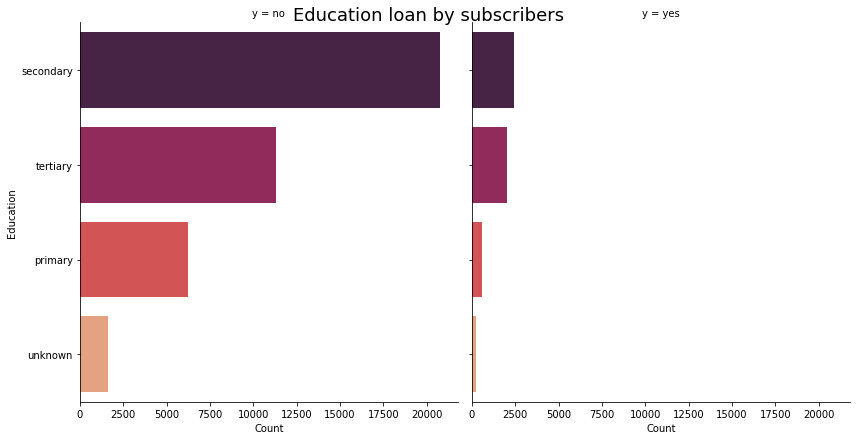

In [51]:
#education
#plot_category('education', order=True, title='Job distribution among clients', yaxis='Job', xaxis='Count')
plot_cat(column='education', col='y', xaxis='Count', yaxis='Education', title='Education loan by subscribers', img_filename='deposits_by_education.jpg')

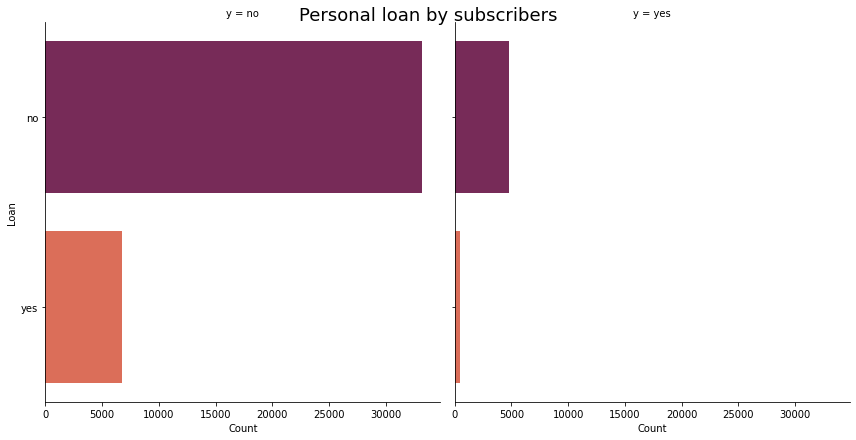

In [50]:
#loan
#plot_category('loan', order=True, title='Job distribution among clients', yaxis='Job', xaxis='Count')
plot_cat(column='loan', col='y', xaxis='Count', yaxis='Loan', title='Personal loan by subscribers', img_filename='deposits_by_loan.jpg')

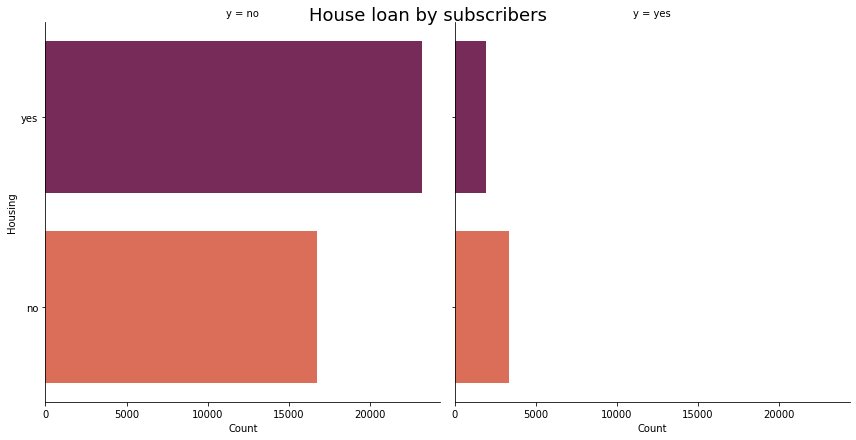

In [49]:
#housing
#plot_category('housing', order=True, title='Job distribution among clients', yaxis='Job', xaxis='Count')
plot_cat(column='housing', col='y', xaxis='Count', yaxis='Housing', title='House loan by subscribers', img_filename='deposits_by_housing.jpg')

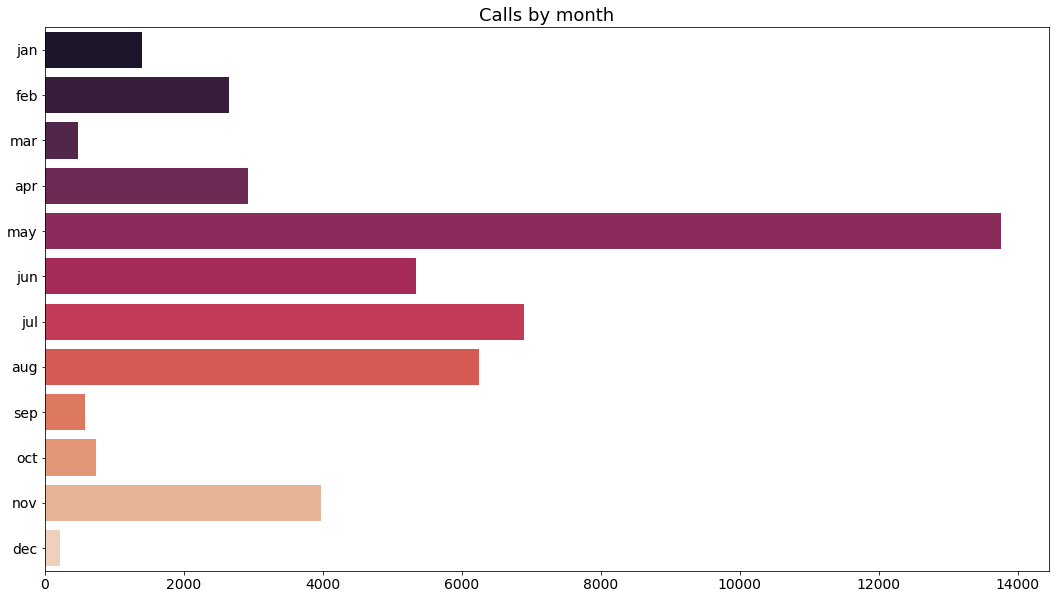

In [41]:
order_month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
plot_category('month',order=order_month, title='Calls by month', img_filename='deposits_by_month.jpg')

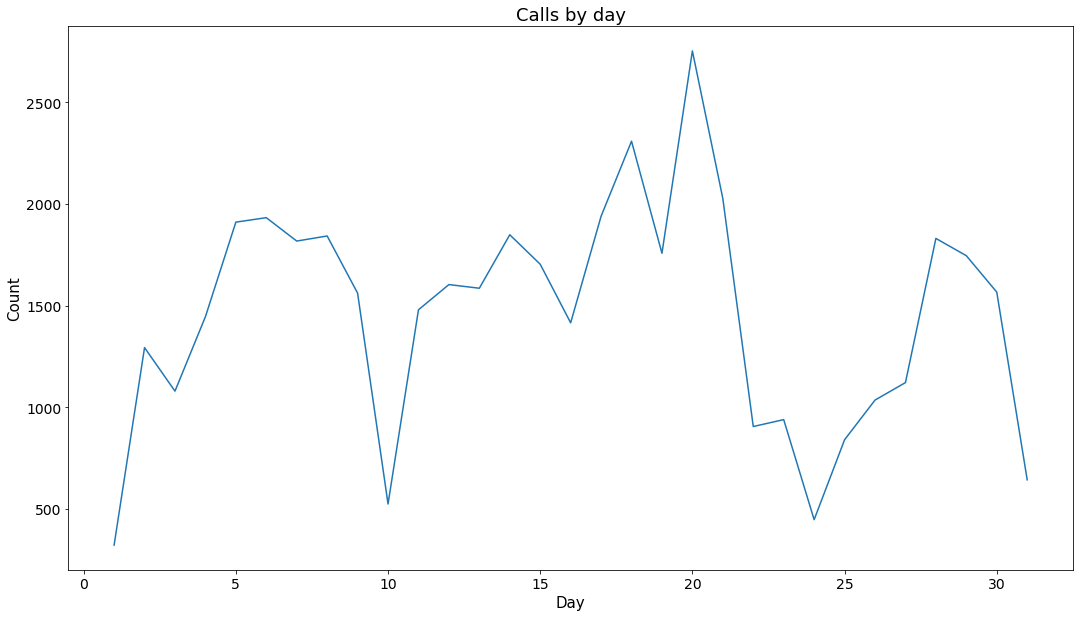

In [22]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.lineplot(x=df['day'].value_counts().index, y=df['day'].value_counts().values)
ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Calls by day', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
fig.savefig('images/contacts_by_day.jpg')
plt.show()

One last thing is that 88% of contacted people do not did a deposit at the bank. I think the marketing team should try to increase call duration, maybe give some coupon codes with a third partner or also give discount to loan (house or personal) interest. As we saw on the EDA, a lot of clients have a housing loan, but they do not have a deposit done during this campaign.

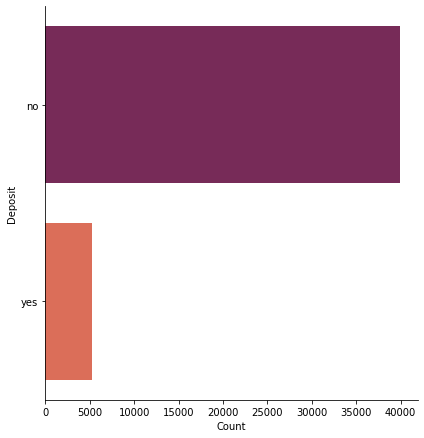

In [23]:
plot_cat(column='y', xaxis='Count', yaxis='Deposit')

In [24]:
df['y'].value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64